In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import os
import matplotlib as mpl
if os.environ.get('DISPLAY', '') == '':
    print('no display found. Using non-interactive Agg backend')
#     mpl.use('Agg')
import future.utils
mpl.rcParams["text.usetex"] = False
sns.set_style("whitegrid")
sns.axes_style("whitegrid")
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
import json
import numpy as np


no display found. Using non-interactive Agg backend


In [2]:
results = pd.read_csv("aggregate/media results final.csv", index_col=[0])
results = results[results['gam'] != 0.25]

In [3]:
results.head()

,n,p,eps,gam,gam_media,p_media,max_it,media_op,avg_ncluster,std_ncluster,...,10B_avg_entr,10B_std_entr,100B_avg_entr,100B_std_entr,10B_norm_entr,100B_norm_entr,avg_ncluster_0.01,std_ncluster_0.01,avg_ncluster_0.00001,std_ncluster_0.00001
0,100,1.0,0.2,0.00,0.00,0.0,1000000,0.05;0.5;0.95,2.142106,0.349939,...,0.800204,0.151014,0.832075,0.154189,0.357246,0.205639,2.142106,0.348185,3.951449,1.986750
1,100,1.0,0.2,0.50,0.50,0.0,1000000,0.05;0.5;0.95,4.472365,2.235050,...,1.364345,0.257030,2.178976,0.415914,0.609103,0.538512,4.467653,2.214858,17.527504,7.327790
2,100,1.0,0.2,0.75,0.75,0.0,1000000,0.05;0.5;0.95,4.438851,2.124890,...,1.381526,0.291040,2.150897,0.495974,0.616774,0.531572,4.440457,2.114218,21.372124,7.349329
3,100,1.0,0.2,1.00,1.00,0.0,1000000,0.05;0.5;0.95,3.978511,1.687577,...,1.366317,0.282660,2.123832,0.435124,0.609983,0.524884,3.974855,1.673121,24.035663,7.503493
4,100,1.0,0.2,1.25,1.25,0.0,1000000,0.05;0.5;0.95,4.188130,1.637470,...,1.429490,0.261430,2.219845,0.373079,0.638187,0.548612,4.187479,1.626057,27.552726,7.422183


In [4]:
gams = list(results.gam.unique())
p_medias = list(results.p_media.unique())
epss = list(results.eps.unique())
mos = list(results.media_op.unique())
print(gams, p_medias, epss, mos)

[0.0, 0.5, 0.75, 1.0, 1.25, 1.5] [0.0, 0.1, 0.2, 0.3, 0.4, 0.5] [0.2, 0.3, 0.4, 0.5] ['0.05;0.5;0.95', '0.05;0.95', '0.0', '0.5']


In [7]:
threemedia = results[results['media_op'] == '0.05;0.5;0.95']
print(len(threemedia))
gams = list(threemedia.gam.unique())
p_medias = list(threemedia.p_media.unique())
epss = list(threemedia.eps.unique())
mos = list(threemedia.media_op.unique())
print(gams, p_medias, epss, mos)

94
[0.0, 0.5, 0.75, 1.0, 1.25, 1.5] [0.0, 0.1, 0.2, 0.3] [0.2, 0.3, 0.4, 0.5] ['0.05;0.5;0.95']


In [8]:
twomedia = results[results['media_op'] == '0.05;0.95']
print(len(twomedia))
gams = list(twomedia.gam.unique())
p_medias = list(twomedia.p_media.unique())
epss = list(twomedia.eps.unique())
mos = list(twomedia.media_op.unique())
print(gams, p_medias, epss, mos)

144
[0.0, 0.5, 0.75, 1.0, 1.25, 1.5] [0.0, 0.1, 0.2, 0.3, 0.4, 0.5] [0.2, 0.3, 0.4, 0.5] ['0.05;0.95']


In [9]:
extremist = results[results['media_op'] == '0.0']
print(len(extremist))
gams = list(extremist.gam.unique())
p_medias = list(extremist.p_media.unique())
epss = list(extremist.eps.unique())
mos = list(extremist.media_op.unique())
print(gams, p_medias, epss, mos)

144
[0.0, 0.5, 0.75, 1.0, 1.25, 1.5] [0.0, 0.1, 0.2, 0.3, 0.4, 0.5] [0.2, 0.3, 0.4, 0.5] ['0.0']


In [10]:
moderate = results[results['media_op'] == '0.5']
print(len(moderate))
gams = list(moderate.gam.unique())
p_medias = list(moderate.p_media.unique())
epss = list(moderate.eps.unique())
mos = list(moderate.media_op.unique())
print(gams, p_medias, epss, mos)

120
[0.0, 0.5, 0.75, 1.0, 1.25, 1.5] [0.1, 0.2, 0.3, 0.4, 0.5] [0.2, 0.3, 0.4, 0.5] ['0.5']


In [41]:
#rifare i plot dal fisso e mettere le label in latex per paper
def heatmapsplotconfronto(results, measure, x='p_media', y='gam', grouping="eps"):

    import string

    params = ['nruns','n', 'gam', 'eps', 'p_media']
    paramsnames = ['nruns', 'n', '$\gamma$', '$\epsilon$', '$p_m$']
    parmapping = dict(zip(params, paramsnames))

    sns.set_style("whitegrid")
    sns.set(font_scale=0.8)

    row_grouping = sorted(list(results[grouping].unique()))
    column_grouping = sorted(list(results['media_op'].unique()))

    with sns.axes_style("whitegrid"):

        fig, axes = plt.subplots(nrows=len(column_grouping), ncols=len(row_grouping), figsize=(15, 8), dpi=600)
        fmt = ".2f"
        annot = True
        if measure=='avg_niter':
            fmt = ".0f"

        list_of_labels = list(string.ascii_lowercase)

        lab = 0
        i = 0
        for val in row_grouping:
            data = results[results["media_op"]==column_grouping[0]]
            data = data[data[grouping] == val]
            df = data.pivot(x, y, measure)
            a=sns.heatmap(df, vmin=min(results[measure]), vmax=max(results[measure]), cmap='RdBu_r', cbar=False, fmt=fmt, annot=annot, ax= axes[0, i])
            axes[0, i].set_ylabel(r'{}'.format(parmapping[x]), fontsize=10)
            axes[0, i].set_xlabel(r'{}'.format(parmapping[y]), fontsize=10)
            axes[0, i].set_title(r'({}) {} $\epsilon$ = {}'.format(list_of_labels[lab], column_grouping[0], val))
            lab +=1
            i+=1

        i = 0
        for val in row_grouping:
            data = results[results["media_op"]==column_grouping[1]]
            data = data[data[grouping] == val]
            df = data.pivot(x, y, measure)
            sns.heatmap(df, vmin=min(results[measure]), vmax=max(results[measure]), cmap='RdBu_r', cbar=False, fmt=fmt, annot=annot, ax= axes[1, i])
            axes[1, i].set_ylabel(r'{}'.format(parmapping[x]), fontsize=10)
            axes[1, i].set_xlabel(r'{}'.format(parmapping[y]), fontsize=10)
            axes[1, i].set_title(r'({}) {} $\epsilon$ = {}'.format(list_of_labels[lab], column_grouping[1], val))
            i+=1
            lab+=1
        
        i = 0
        for val in row_grouping:
            data = results[results["media_op"]==column_grouping[2]]
            data = data[data[grouping] == val]
            df = data.pivot(x, y, measure)
            sns.heatmap(df, vmin=min(results[measure]), vmax=max(results[measure]), cmap='RdBu_r', cbar=False, fmt=fmt, annot=annot, ax= axes[2, i])
            axes[2, i].set_ylabel(r'{}'.format(parmapping[x]), fontsize=10)
            axes[2, i].set_xlabel(r'{}'.format(parmapping[y]), fontsize=10)
            axes[2, i].set_title(r'({}) {} $\epsilon$ = {}'.format(list_of_labels[lab], column_grouping[2], val))
            i+=1
            lab+=1
        
        i = 0
        for val in row_grouping:
            data = results[results["media_op"]==column_grouping[3]]
            data = data[data[grouping] == val]
            df = data.pivot(x, y, measure)
            sns.heatmap(df, vmin=min(results[measure]), vmax=max(results[measure]), cmap='RdBu_r', cbar=False, fmt=fmt, annot=annot, ax= axes[3, i])
            axes[3, i].set_ylabel(r'{}'.format(parmapping[x]), fontsize=10)
            axes[3, i].set_xlabel(r'{}'.format(parmapping[y]), fontsize=10)
            axes[3, i].set_title(r'({}) {} $\epsilon$ = {}'.format(list_of_labels[lab], column_grouping[3], val))
            i+=1
            lab+=1
        
        for ax in axes.flat:
            ax.tick_params(axis='x', which='major', pad=-2)
            ax.tick_params(axis='y', which='major', pad=-2)
        
        cax = fig.add_axes([0.9, 0.3, 0.01, 0.6])
        cbar = fig.colorbar(ax.get_children()[0], cax=cax, orientation="vertical")
        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(10)

        plt.subplots_adjust(hspace=1.0)
        plt.savefig("plots/aggregate/hm confronto setting {}.png".format(measure))
        plt.show()
        plt.close()

In [42]:
measures = list(results.columns)[8:19]
print(measures)

['avg_ncluster', 'std_ncluster', 'avg_pwdist', 'std_pwdist', 'avg_niter', 'std_niter', 'avg_opinion', 'std_opinions', 'median_opinion', '10B_avg_entr', '10B_std_entr']


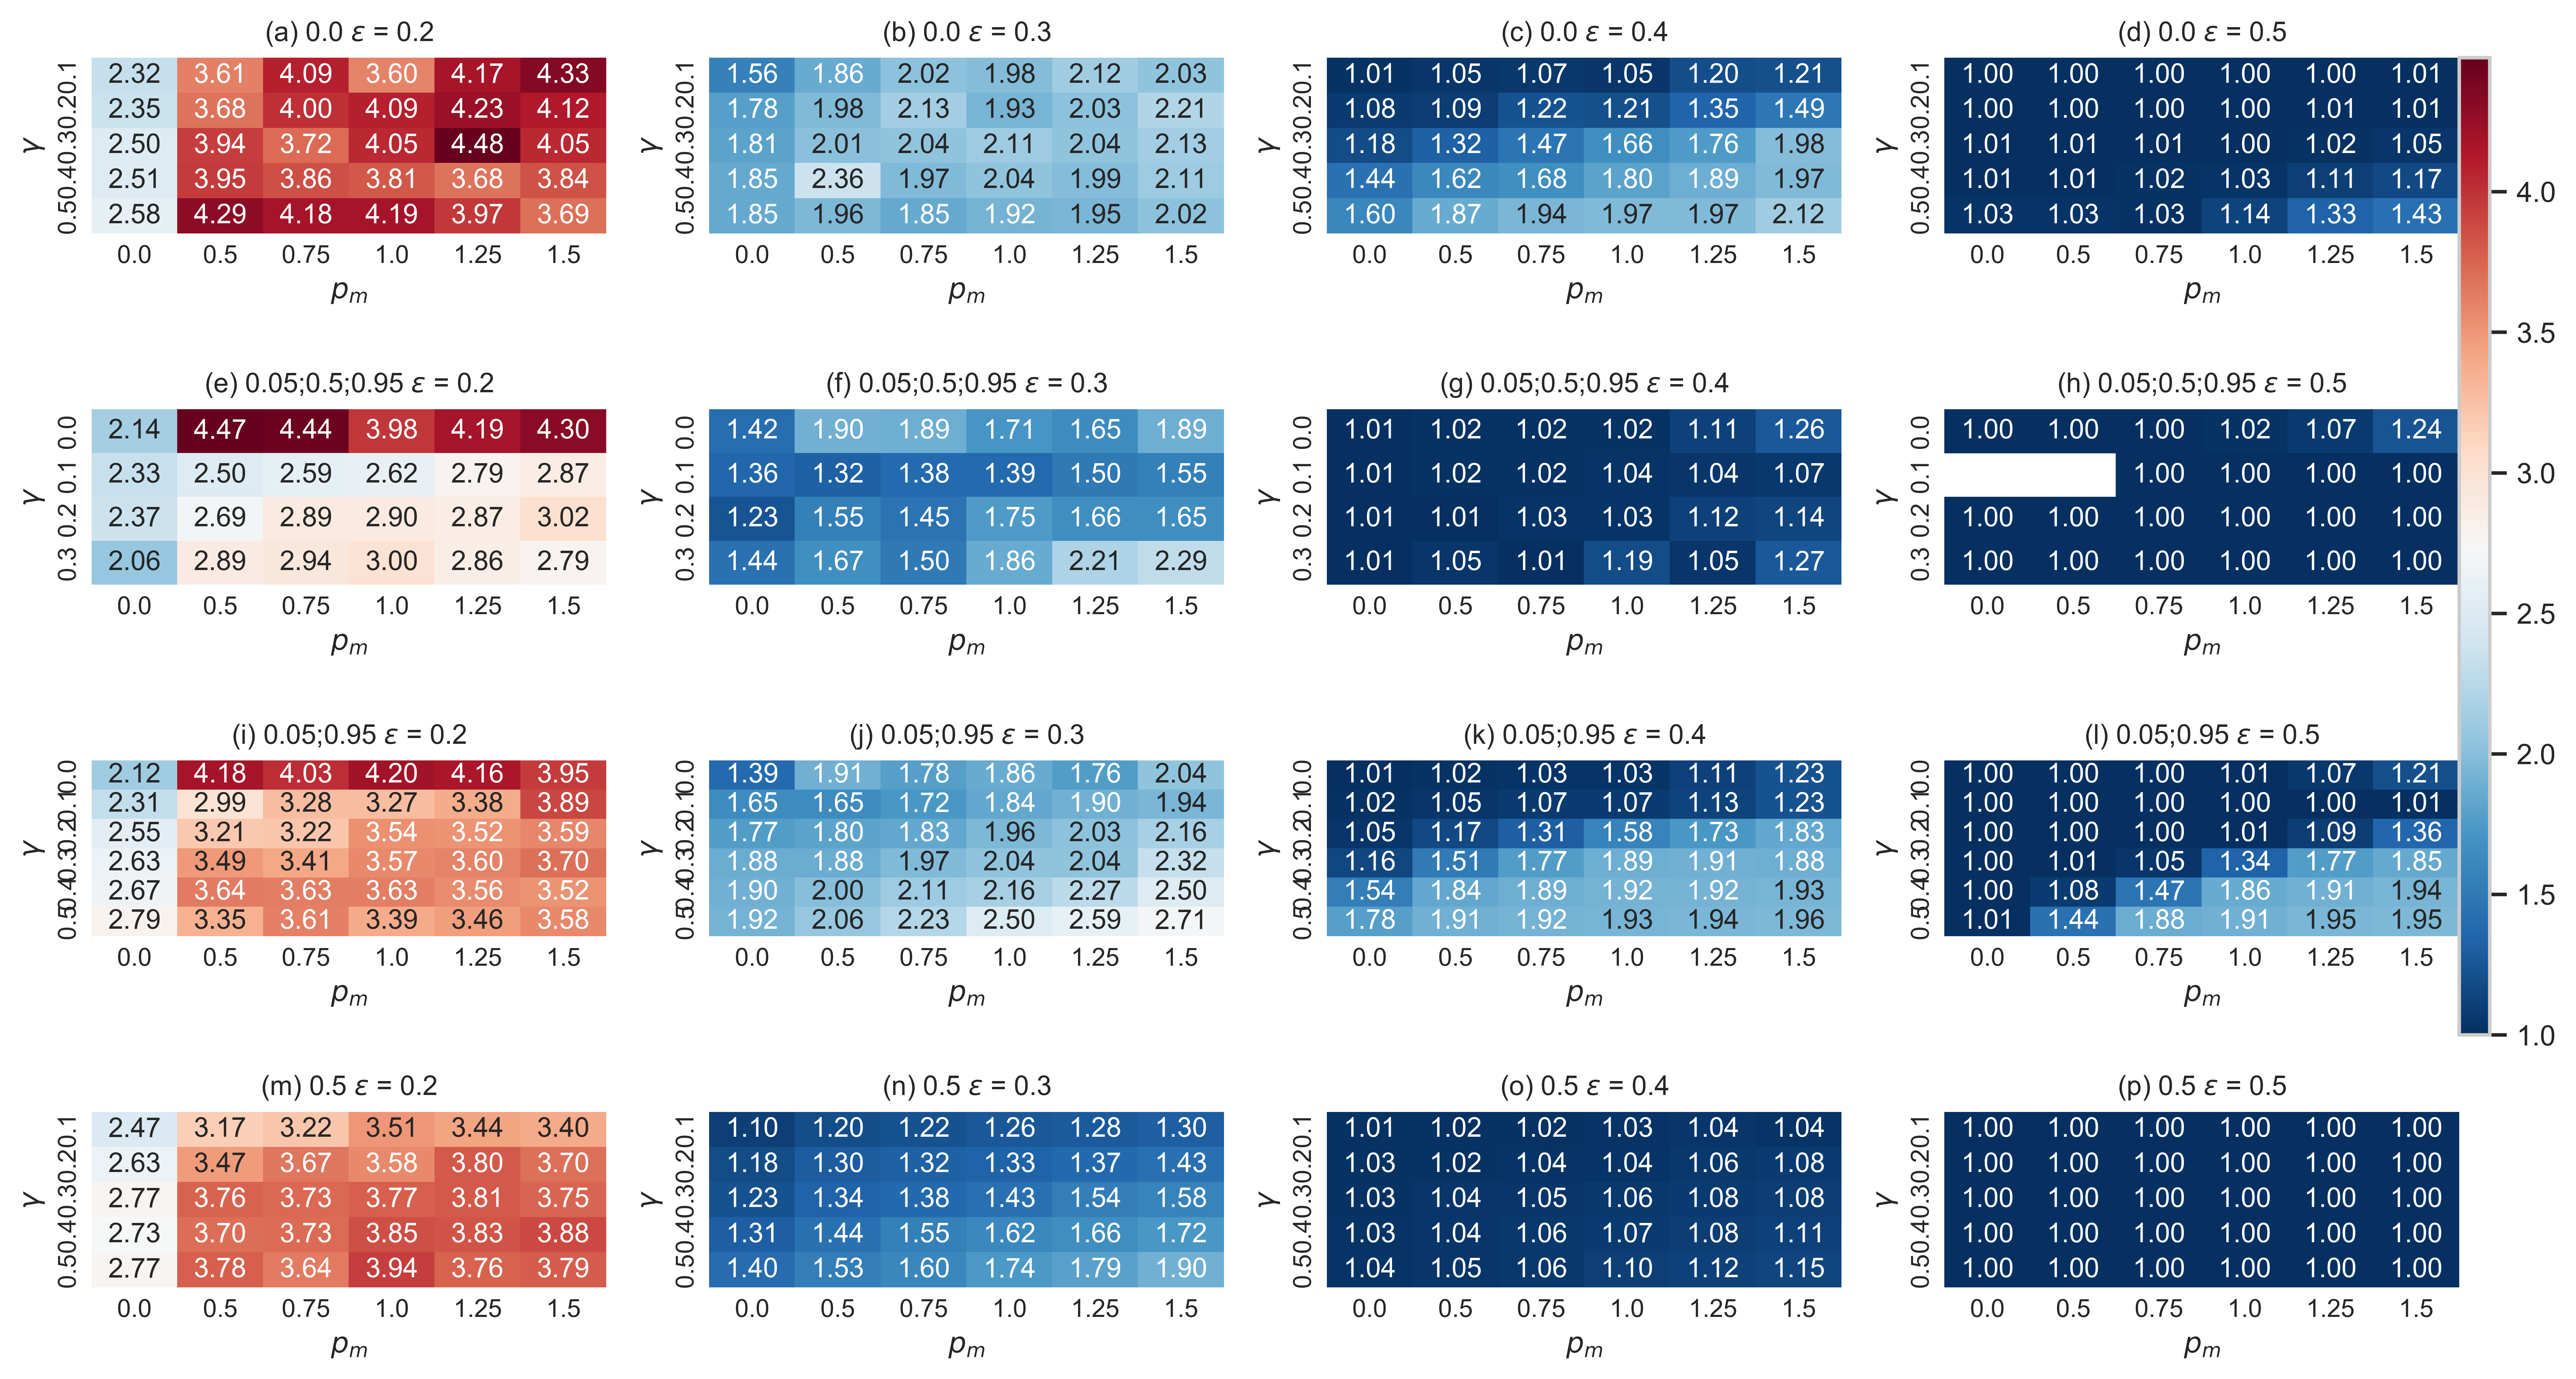

In [43]:
model = "media"
for measure in measures:
    heatmapsplotconfronto(results, measure)
    break

In [5]:
def from_res_to_iterations(name, nr):
    res = open("res/{} nr{}.csv".format(name, nr))
    iterations = []
    it = 0
    for line in res.readlines():
        iterations.append(dict())
        iterations[it]['iteration'] = it
        iterations[it]['status'] = dict()

        opinions = line.strip().split(',')

        for i in range(len(opinions)):
            iterations[it]['status'][i] = float(opinions[i])
            iterations[it]['node_count'] = {0: 0},
            iterations[it]['status_delta'] = {0: 0}

        it += 1
        
    return iterations

In [6]:
def evolution(iterations, fig, ax):

    """
    Generates the plot

    :param filename: Output filename
    :param percentile: The percentile for the trend variance area
    """

    nodes2opinions = {}
    node2col = {}

    last_it = iterations[-1]['iteration'] + 1
    last_seen = {}

    for it in iterations:
        sts = it['status']
        its = it['iteration']
        for n, v in sts.items():
            if n in nodes2opinions:
                last_id = last_seen[n]
                last_value = nodes2opinions[n][last_id]

                for i in range(last_id, its):
                    nodes2opinions[n][i] = last_value

                nodes2opinions[n][its] = v
                last_seen[n] = its
            else:
                nodes2opinions[n] = [0]*last_it
                nodes2opinions[n][its] = v
                last_seen[n] = 0
                if v < 0.33:
                    node2col[n] = '#3776ab'
                elif 0.33 <= v <= 0.66:
                    node2col[n] = '#FFA500'
                else:
                    node2col[n] = '#FF0000'

    mx = 0
    for k, l in future.utils.iteritems(nodes2opinions):
        if mx < last_seen[k]:
            mx = last_seen[k]
        x = list(range(0, last_seen[k]))
        y = l[0:last_seen[k]]
        ax.plot(x, y, lw=1, alpha=0.25, color=node2col[k])
    
    ax.set_ylim(-0.1, 1.1)
    # ax.set_xlim(0, 1000)
    ax.tick_params(axis='both', which='major', labelsize=4, pad=0)                
    # plt.grid(axis = 'both', which='both')
    plt.tight_layout()


def finaldistribution(name, nr, ax):
    sns.set_style("whitegrid")
    jsonfile = open(f'aggregate/final_opinions {name}.json')
    data = json.load(jsonfile)
    finalops = list(data[str(nr)])
    x = [i for i in range(100)]
    y = sorted(finalops)    
    node2col = {}
    for node in x:
        if y[node] < 0.33:
            node2col[node] = '#3776ab'
        elif 0.33 <= y[node] <= 0.66:
            node2col[node] = '#FFA500'
        else:
            node2col[node] = '#FF0000'
    for node in x:
        ax.scatter(x[node], y[node], s = 0.2, c = node2col[node])
    ax.set_ylim(-0.1, 1.1)
    ax.tick_params(axis='both', which='major', labelsize=3, pad=2)    
    ax.set_ylabel(r'$opinion$', fontsize=3)
    ax.set_xlabel(r'$node$', fontsize=3)
    plt.grid(axis = 'both', which='both')
    plt.tight_layout()

In [14]:
from tqdm import tqdm
def spaghettigridbye(results):
    mops = list(results.media_op.unique())
    pmlist = list(results.p_media.unique())
    elist = list(results.eps.unique())
    glist = list(results.gam.unique())
    sns.set_style("whitegrid")
    for mo in ["0.05;0.95"]:
        for e in elist:
            with tqdm(total=len(pmlist)*len(glist)) as pbar:
                fig, axes = plt.subplots(nrows=len(pmlist), ncols=len(glist), figsize=(len(glist), len(pmlist)), dpi=600, sharey=True)
                row=0
                for pm in pmlist:
                    col=0
                    for g in glist: 
                        mo = ", ".join(mo.split(";"))
                        name = f'media mo[{mo}] p{pm} e{e} g{g} gm{g} mi1000000'
                        nr = 1
                        iterations = from_res_to_iterations(name, nr)
                        evolution(iterations, fig=fig, ax=axes[row,col])
                        col+=1
                        pbar.update(1)
                    row+=1
            name = f'media mo[{mo}] e{e}'
            plt.savefig(f"plots/aggregate/evolution/spaghettigrid {name} mi1000000.png")
            plt.close()

In [12]:
def finaldistributiongridbye():
    mops = list(results.media_op.unique())
    pmlist = list(results.p_media.unique())
    elist = list(results.eps.unique())
    glist = list(results.gam.unique())
    sns.set_style("whitegrid")
    for mo in ["0.05;0.95"]:
        for e in elist:
            with tqdm(total=len(pmlist)*len(glist)) as pbar:
                fig, axes = plt.subplots(nrows=len(pmlist), ncols=len(glist), figsize=(len(glist), len(pmlist)), dpi=600, sharey=True)
                row=0
                for pm in pmlist:
                    col=0
                    for g in glist: 
                        mo = ", ".join(mo.split(";"))
                        name = f'media mo[{mo}] p{pm} e{e} g{g} gm{g} mi1000000'
                        finaldistribution(name, 1, axes[row, col])
                        col+=1
                        pbar.update(1)
                    row+=1
                name = f'media mo[{mo}] e{e}'
                plt.savefig(f"plots/aggregate/distribution/distributiongrid {name} mi1000000.png")
                plt.close()

In [15]:
spaghettigridbye(results)

100%|██████████| 36/36 [01:16<00:00,  2.11s/it]


In [13]:
finaldistributiongridbye()

100%|██████████| 36/36 [01:21<00:00,  2.25s/it]
